## Introduction: Wafer Defect Patterns Classifier in Semiconductor Manufacturing Industry Application

The objective of this notebook is to build a Convolutional Neural Network (CNN) based classificiation model to study the defect types of the silicon wafers. 

In semiconductor industry, wafer manufacturing quality is one of the most important factors contributing to the final performance of the finished chip / semiconductor devices. Hence, quality control on the wafer manufacturing is vital in semiconductor industry. However, it is very often that we got different defects during wafer production due to different reasons, e.g. strains, pressure, moisture, temperature gradient, etc. Therefore, if we know the type of the defect that each wafer has, we will be able to pindown what might have caused the defects. We can then make relevant adjustments on the fabrication condition to improve the situations.

By investigating the defect types manually by people is going to be expensive in terms of time and finance, as we need an expert onsite to constantly investigating the defect types of the produced wafers. In order to make this process cost-effective, we need to automate the defect detection process and we need to build an automated system that's both fast and accurate. 

In industry, we look at the electrical mappings of each wafer and the distributions of the abnormality electrical spots on the wafer map are indications of defect and the patterns of those spots relate to the types of each defect 

### 1. Load all the libraries for this project

In [2]:
from numpy import load
import numpy as np
import os
from sklearn.model_selection import train_test_split
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import math
from torch.utils.data import DataLoader
import pandas as pd

### 2. Load the data used for the model training

The data is contributed by J.Wang, C.Xu, et al. and is public on Kaggle (https://www.kaggle.com/datasets/co1d7era/mixedtype-wafer-defect-datasets).

In [3]:
data = load(r"D:\machine learning dataset\archive\Wafer_Map_Datasets.npz")

In [4]:
data.files

['arr_0', 'arr_1']

Now we know in this npz file, there are only two columns of data, i.e. 'arr_0' and 'arr_1'

We now assign the first column as x and the second column as y

In [5]:
x = data['arr_0']
y = data['arr_1']

In [6]:
print('x is type: ' + str(type(x)))
print('y is type: ' + str(type(y)))

x is type: <class 'numpy.ndarray'>
y is type: <class 'numpy.ndarray'>


All the data are in numpy.ndarray type

In [7]:
print('x shape: ' + str(x.shape))
print('y shape: ' + str(y.shape))

x shape: (38015, 52, 52)
y shape: (38015, 8)


particularly for x, the image size is 52 x 52 and there are 38015 images in this dataset

Now we need to check if there are any Null / NaN data in the dataset

In [8]:
print('x has %s NaN data' % str(np.isnan(x).sum()))
print('y has %s NaN data' % str(np.isnan(y).sum()))

x has 0 NaN data
y has 0 NaN data


Let's have a look at our label data y

In [9]:
y[:5]

array([[1, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 1, 0, 0, 0, 1, 0]])

As described in the data instruction, the label data for each image is in one-hot-encoder mode and it has 8 digits. Also according to the data specs, there are 38 types of defects.

Now we need to decode each label into an integer number. This is to make the model training easier.

In [10]:
#label decoder code - this is to decode the 8-digit one-hot code into a unique integer number
def code2class(label):
    if (label.tolist() == [0,0,0,0,0,0,0,0]):
        return 0
    elif (label.tolist() == [1,0,0,0,0,0,0,0]):
        return 1
    elif (label.tolist() == [0,1,0,0,0,0,0,0]):
        return 2
    elif (label.tolist() == [0,0,1,0,0,0,0,0]):
        return 3
    elif (label.tolist() == [0,0,0,1,0,0,0,0]):
        return 4
    elif (label.tolist() == [0,0,0,0,1,0,0,0]):
        return 5
    elif (label.tolist() == [0,0,0,0,0,1,0,0]):
        return 6
    elif (label.tolist() == [0,0,0,0,0,0,1,0]):
        return 7
    elif (label.tolist() == [0,0,0,0,0,0,0,1]):
        return 8
    elif (label.tolist() == [1,0,1,0,0,0,0,0]):
        return 9
    elif (label.tolist() == [1,0,0,1,0,0,0,0]):
        return 10
    elif (label.tolist() == [1,0,0,0,1,0,0,0]):
        return 11
    elif (label.tolist() == [1,0,0,0,0,0,1,0]):
        return 12
    elif (label.tolist() == [0,1,1,0,0,0,0,0]):
        return 13
    elif (label.tolist() == [0,1,0,1,0,0,0,0]):
        return 14
    elif (label.tolist() == [0,1,0,0,1,0,0,0]):
        return 15
    elif (label.tolist() == [0,1,0,0,0,0,1,0]):
        return 16
    elif (label.tolist() == [0,0,1,0,1,0,0,0]):
        return 17
    elif (label.tolist() == [0,0,1,0,0,0,1,0]):
        return 18
    elif (label.tolist() == [0,0,0,1,1,0,0,0]):
        return 19
    elif (label.tolist() == [0,0,0,1,0,0,1,0]):
        return 20
    elif (label.tolist() == [0,0,0,0,1,0,1,0]):
        return 21
    elif (label.tolist() == [1,0,1,0,1,0,0,0]):
        return 22
    elif (label.tolist() == [1,0,1,0,0,0,1,0]):
        return 23
    elif (label.tolist() == [1,0,0,1,1,0,0,0]):
        return 24
    elif (label.tolist() == [1,0,0,1,0,0,1,0]):
        return 25
    elif (label.tolist() == [1,0,0,0,1,0,1,0]):
        return 26
    elif (label.tolist() == [0,1,1,0,1,0,0,0]):
        return 27
    elif (label.tolist() == [0,1,1,0,0,0,1,0]):
        return 28
    elif (label.tolist() == [0,1,0,1,1,0,0,0]):
        return 29
    elif (label.tolist() == [0,1,0,1,0,0,1,0]):
        return 30
    elif (label.tolist() == [0,1,0,0,1,0,1,0]):
        return 31
    elif (label.tolist() == [0,0,1,0,1,0,1,0]):
        return 32
    elif (label.tolist() == [0,0,0,1,1,0,1,0]):
        return 33
    elif (label.tolist() == [1,0,1,0,1,0,1,0]):
        return 34
    elif (label.tolist() == [1,0,0,1,1,0,1,0]):
        return 35
    elif (label.tolist() == [0,1,1,0,1,0,1,0]):
        return 36
    elif (label.tolist() == [0,1,0,1,1,0,1,0]):
        return 37

#### 2.1 initial data visualization

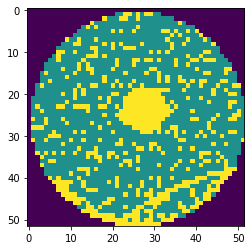

In [11]:
import matplotlib.pyplot as plt
plt.imshow(data['arr_0'][777])

In [12]:
# split the data into training and testing data
X_train, X_valtest, y_train, y_valtest = train_test_split(x, y, test_size = 0.2, random_state = 32, stratify = y)

In [13]:
#decode the label data for the training and testing set
train_y = []
test_y = []

for i in range(y_train.shape[0]):
    train_y.append(code2class(y_train[i]))
for i in range(y_valtest.shape[0]):
    test_y.append(code2class(y_valtest[i]))

#### This is to check some of the images in the training set, just to make sure everything is working well before the model training

Type:4, 0, 11, 5


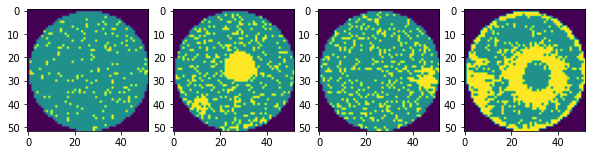

In [14]:
plt.figure(figsize = (10,5))
for i in range(1,5):
    plt.subplot(1,4,i)
    plt.imshow(X_train[i])
print('Type:' + str(train_y[0]) + ', '+ str(train_y[1]) + ', '+ str(train_y[2]) + ', '+ str(train_y[3]))

### 3. Model building

I am building my model based on the simple yet powerful LeNET configuration. The typical LeNET5 has the configuration of the following:

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

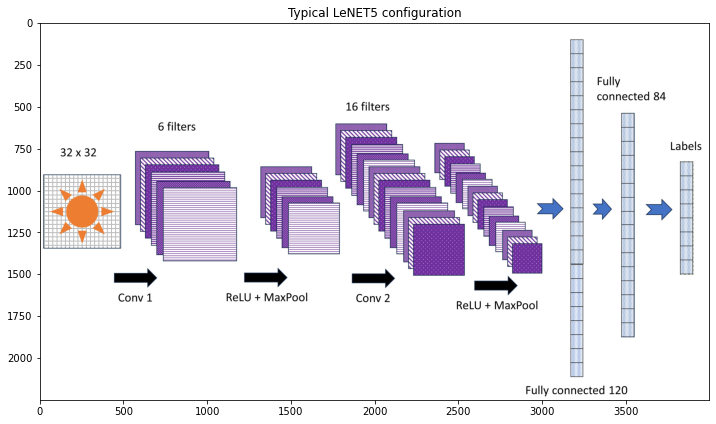

In [5]:

plt.figure(figsize = (12,9))
 
plt.title("Typical LeNET5 configuration")
 
image = mpimg.imread(".\LeNET5.jpg")
plt.imshow(image)
plt.show()

A typical LeNET5 has the configuration of:

Input: 32 x 32 image (single channel or RGB channel)
1. First convolutional layer with 6 filters, 5 x 5 kernel size
2. First Max Pooling layer with a kernel size of 2 x 2
3. Second convolutional layer with 16 filters, 5 x 5 kernel size
4. Second Max Pooling layer with a kernel size of 2 x 2
5. First Fully connected layer with an input size of 120
6. Second Fully connected layer with an input size of 84

Output layer with the number of the classes in the dataset

However, this network needs to be customized to adapt to this specific dataset of wafer defect maps. By taking into consideration of the model fitting regularizations, I am putting some dropout layers between the fully connected layers. This is to prevent overfitting of the model. 

In order to customize the model, we need to identify the hyperparameters first in this configuration, and they are:

1. output number of the 1st conv layer
2. kernel size of the 1st conv layer
3. kernel size of the 1st pooling layer
4. stride size of the 1st pooling layer
5. output number of the 2nd conv layer
6. kernel size of the 2nd conv layer
7. kernel size of the 2nd pooling layer
8. stride size of the 2nd pooling layer
9. output number of the 1st fully connected layer
10. output number of the 2nd fully connected layer
11. different dropout rates for different dropout layers 1, 2 and 3
12. learning rate of the optimizer function
13. weight decaying number of the optimizer (I am choosing Adam optimizer for a better regularized model fitting)

So in total there are 13 hyperparameters to tune for this customized LeNET configuration.

#### Model building flow

In order to find out the optimal hyperparameters, we need to use an appropriate hyperparameter searching strategy. There are 3 popular strategies in terms of hyperparameters optimizations: 

1. Bayesian Otimization
2. Random Search
3. Grid Search

As I have a rather large dataset (>30k samples) and high dimensional feature numbers (13), Grid search would be very inefficient and computaionally expensive. Random Search can significantly lower the computation cost, but it would be very inefficient search for this very large search space if doing randomly. 

Therefore, by using a statistical searching approach -- Bayesian Optimization, can yield an appriopriate solution for searching the hyperparameters.

So now we need to build a pipeline function that wraps the model builging, data training and data testing functions together. This wrapper function needs to contain all the hyperparameters and yield the final testing score (testing accuracty). 

Then to feed this wrapper function into the Bayesian Optimization function for iterative optimizations to maximize the testing score while statistically searching for the optimal hyperparameters. 

#### 3.1 data transformer building

First, we need to build a data transformer so to transform our npz (numpy.array, 52 x 52 x 1) dataset into a deep learning trainable dataset (tensor, 32 x 32 x 1 size and normalized)

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5, ), (0.5, ))
])

#### 3.2 data transformation using the transformer

This is to transform all the training and testing data for the later model traininng 

In [17]:
X_train_transformed = []
X_train1 = X_train.astype(np.float32)
for sample in X_train1:
    transformed_sample = transform(sample)
    X_train_transformed.append(transformed_sample)

# Convert the list to a PyTorch tensor
X_train_transformed = torch.stack(X_train_transformed)

traindata_X = X_train_transformed
traindata_y = train_y


X_test_transformed = []
X_test1 = X_valtest.astype(np.float32)
for sample in X_test1:
    transformed_sample = transform(sample)
    X_test_transformed.append(transformed_sample)

# Convert the list to a PyTorch tensor
X_test_transformed = torch.stack(X_test_transformed)

test_x = X_test_transformed

D:\Anaconda\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [49]:
X_train_transformed.shape

torch.Size([30412, 1, 32, 32])

In [50]:
X_test_transformed.shape

torch.Size([7603, 1, 32, 32])

Now after the transformation, we can the the training and testing data have been nicely transformed into a 4D tensor (num of samples, number of channel, height of the image, width of the image). Now they are ready for the model training 

We also need to define a batch size for the model training. Normally we set it as 64, which means that we divide our training set into many mini batches and each batch contain 64 datapoints. We use this minibatch to keep training the model and updating the model parameters

In [18]:
batchsize = 64

Also we need to know that all those transformed data and the batchsize are global variables, and need to be defined outside our wrapper function to be defined

#### 3.3 Wrapper function definition
In this wrapper function, the inputs are 13 hyperparameters described above, and the output would be the testing score / accuracy for the trained model testing on the testing dataset

This wrapper function will directly be fed into the Bayesian Optimization function later for hyperparameter searching / optimizations

####  The model: LeNET based model with modifications

As mentioned earlier, I am choosing LeNET as my model basis as it's a simple yet powerful model for image classification problems. The simpleness will help prevent data overfitting in general. 

I have put some modifications in this customized model, for example, batch normalizations, dropout layers for further model regularizations

Also I am choosing Adam optimizer as it has another regularization tuning paramereter -- weight decaying parameter. These will help the model with overfitting problems. 

I have made two wrapper functions LeNET5CNN and LeNET5CNN2. The only difference between these two functions is that LeNET5CNN has only one output -- testing score, so LeNET5CNN is for the Bayesian Optimization. LeNET5CNN2 has two outputs -- the testing score and the trained model.

After the Bayesian Optimization, we found the appropriate hyperparameters and we can feed it into LeNET5CNN2 to output the trained model. Then we can use this trained model to test our training accuracy separately on a larger basis instead of only in the mini batch size

In [19]:
import torch.optim as optim
def LeNET5CNN(CONV1OUT, CONV1F, POOL1F, POOL1S, CONV2OUT, CONV2F, FC1OUT, FC2OUT, DRP1, DRP2, DRP3, LR, WD):
    
    #Model building: LeNET based model with modifications
    class CNNnet(nn.Module):
        def __init__(self, name = None, inchn = None, conv1out = None, conv1filter = None, pool1f = None, pool1s = None, \
                conv2out = None, conv2filter = None, fc1out = None, fc2out = None, dp1 = None, dp2 = None, dp3 = None):
            super(CNNnet, self).__init__()
            if name:
                self.name = name
            self.conv1out = conv1out
            self.conv1filter = conv1filter 
            self.pool1f = pool1f
            self.pool1s = pool1s
            self.conv2out = conv2out
            self.conv2filter = conv2filter 
            self.fc1out = fc1out
            self.dp1 = dp1
            self.fc2out = fc2out
            self.dp2 = dp2
            self.dp3 = dp3
            self.conv1 = nn.Conv2d(1, conv1out, conv1filter)
            self.bn1 = nn.BatchNorm2d(conv1out)
            self.f1mps = (32 - conv1filter) / 1 + 1
            self.pool = nn.MaxPool2d(pool1f, pool1s)
            self.f2mps = math.floor(((self.f1mps - pool1f) / pool1s) + 1)
            self.conv2 = nn.Conv2d(conv1out, conv2out, conv2filter)
            self.bn2 = nn.BatchNorm2d(conv2out)
            self.f3mps = (self.f2mps - conv2filter) / 1 + 1
            self.f4mps = math.floor(((self.f3mps - pool1f) / pool1s) + 1)
            self.drop1 = nn.Dropout(dp1)
            self.fc1 = nn.Linear(conv2out * self.f4mps * self.f4mps, fc1out)
            self.drop2 = nn.Dropout(dp2)
            self.fc2 = nn.Linear(fc1out, fc2out)
            self.drop3 = nn.Dropout(dp3)
            self.fc3 = nn.Linear(fc2out, 38)

            total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
            print(self.name + ': total params:', total_params)

        def forward(self, x):
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = x.view(-1, self.conv2out * self.f4mps * self.f4mps)
            x = F.relu(self.fc1(x))
            x = self.drop2(x)
            x = F.relu(self.fc2(x))
            x = self.drop3(x)
            x = self.fc3(x)
            return x
    
    net = CNNnet(name = 'LeNET5', conv1out = round(CONV1OUT), conv1filter = round(CONV1F),  pool1f = round(POOL1F), pool1s = round(POOL1S), \
                conv2out = round(CONV2OUT), conv2filter = round(CONV2F),  fc1out = round(FC1OUT), fc2out = round(FC2OUT), dp1 = round(DRP1), dp2 = round(DRP2), dp3 = round(DRP3))
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr = LR, weight_decay= WD)
    model = net
    
    for epoch in range(3):
        running_loss = 0
        chk = 0
        batch_trainx = []
        batch_trainy = []
        traindata = []
        for i, val in enumerate(traindata_y):
            traindata.append((traindata_X[i], traindata_y[i]))
        for i, data in enumerate(traindata):
            chk += 1
            img, label = data
            batch_trainx.append(img)
            batch_trainy.append(label)
            if (chk == batchsize):
                batch_trainx = torch.stack(batch_trainx)
                #training code for a batch-start
                running_loss = 0
                optimizer.zero_grad()
                output = model(batch_trainx)
                loss = criterion(output, torch.Tensor(batch_trainy).type(torch.LongTensor))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                #training code for a batch-end
                chk = 0
                batch_trainx = []
                batch_trainy = []
                #print(running_loss)
    correct = 0
    total = 0
    
    output_test = model(test_x)
    _, predictedtest = torch.max(output_test, 1)
    score = (sum(np.array(predictedtest.tolist()) == np.array(test_y)) / len(test_y)) * 100
    return score
    

In [20]:
import torch.optim as optim #return model and the testing score
def LeNET5CNN2(CONV1OUT, CONV1F, POOL1F, POOL1S, CONV2OUT, CONV2F, FC1OUT, FC2OUT, DRP1, DRP2, DRP3, LR, WD):
    
    class CNNnet(nn.Module):
        def __init__(self, name = None, inchn = None, conv1out = None, conv1filter = None, pool1f = None, pool1s = None, \
                conv2out = None, conv2filter = None, fc1out = None, fc2out = None, dp1 = None, dp2 = None, dp3 = None):
            super(CNNnet, self).__init__()
            if name:
                self.name = name
            self.conv1out = conv1out
            self.conv1filter = conv1filter 
            self.pool1f = pool1f
            self.pool1s = pool1s
            self.conv2out = conv2out
            self.conv2filter = conv2filter 
            self.fc1out = fc1out
            self.dp1 = dp1
            self.fc2out = fc2out
            self.dp2 = dp2
            self.dp3 = dp3
            self.conv1 = nn.Conv2d(1, conv1out, conv1filter)
            self.bn1 = nn.BatchNorm2d(conv1out)
            #self.f1mps = (32 - conv1filter) / conv1strd + 1
            self.f1mps = (32 - conv1filter) / 1 + 1
            self.pool = nn.MaxPool2d(pool1f, pool1s)
            self.f2mps = math.floor(((self.f1mps - pool1f) / pool1s) + 1)
            self.conv2 = nn.Conv2d(conv1out, conv2out, conv2filter)
            self.bn2 = nn.BatchNorm2d(conv2out)
            #self.f3mps = (self.f2mps - conv2filter) / conv2strd + 1
            self.f3mps = (self.f2mps - conv2filter) / 1 + 1
            self.f4mps = math.floor(((self.f3mps - pool1f) / pool1s) + 1)
            self.drop1 = nn.Dropout(dp1)
            self.fc1 = nn.Linear(conv2out * self.f4mps * self.f4mps, fc1out)
            self.drop2 = nn.Dropout(dp2)
            self.fc2 = nn.Linear(fc1out, fc2out)
            self.drop3 = nn.Dropout(dp3)
            self.fc3 = nn.Linear(fc2out, 38)

            total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
            print(self.name + ': total params:', total_params)

        def forward(self, x):
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = x.view(-1, self.conv2out * self.f4mps * self.f4mps)
            #x = x.view(x.size(0), -1)
            #x = self.drop1(x)
            x = F.relu(self.fc1(x))
            x = self.drop2(x)
            x = F.relu(self.fc2(x))
            x = self.drop3(x)
            x = self.fc3(x)
            return x
    
    net = CNNnet(name = 'LeNET5', conv1out = round(CONV1OUT), conv1filter = round(CONV1F),  pool1f = round(POOL1F), pool1s = round(POOL1S), \
                conv2out = round(CONV2OUT), conv2filter = round(CONV2F),  fc1out = round(FC1OUT), fc2out = round(FC2OUT), dp1 = round(DRP1), dp2 = round(DRP2), dp3 = round(DRP3))
    
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(net.parameters(), lr = LR, momentum = MT)
    optimizer = optim.Adam(net.parameters(), lr = LR, weight_decay= WD)
    model = net
    
    for epoch in range(3):
        running_loss = 0
        chk = 0
        batch_trainx = []
        batch_trainy = []
        traindata = []
        for i, val in enumerate(traindata_y):
            traindata.append((traindata_X[i], traindata_y[i]))
        for i, data in enumerate(traindata):
            chk += 1
            img, label = data
            batch_trainx.append(img)
            batch_trainy.append(label)
            if (chk == batchsize):
                batch_trainx = torch.stack(batch_trainx)
                #training code for a batch-start
                running_loss = 0
                optimizer.zero_grad()
                output = model(batch_trainx)
                loss = criterion(output, torch.Tensor(batch_trainy).type(torch.LongTensor))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                #training code for a batch-end
                chk = 0
                batch_trainx = []
                batch_trainy = []
                #print(running_loss)
    correct = 0
    total = 0
    
    output_test = model(test_x)
    _, predictedtest = torch.max(output_test, 1)
    score = (sum(np.array(predictedtest.tolist()) == np.array(test_y)) / len(test_y)) * 100
    return score, model

#### 3.4 Bayesian Optimization process definition

I am using the library bayes_opt for Bayesian Optimization process

In [55]:
from bayes_opt import BayesianOptimization

This is to define boundaries for each hyperparameter in Bayesian Optimization search

In [87]:
para_bounds = {
    'CONV1OUT': (2,9),
    'CONV1F': (3,7),
    'POOL1F': (1,4),
    'POOL1S': (1,3),
    'CONV2OUT': (7,20),
    'CONV2F': (3,7),
    'FC1OUT': (50,190),
    'FC2OUT': (50, 190),
    'DRP1': (0.01,0.9),
    'DRP2': (0.01,0.9),
    'DRP3': (0.01,0.9),
    'LR': (0.001,0.05),
    'WD': (0.1e-04, 30e-04)

}

In [88]:
LGB_BO = BayesianOptimization(LeNET5CNN, para_bounds, random_state=7)

I started with the typical LeNET5 configuration. This is to set a probe for the Bayesian Optimization and the algorithm will start searching based on this initial setup

In [89]:
LGB_BO.probe(
    params = 
    {
    'CONV1OUT': 6,
    'CONV1F': 5,
    'POOL1F': 2,
    'POOL1S': 2,
    'CONV2OUT': 16,
    'CONV2F': 5,
    'FC1OUT': 120,
    'FC2OUT': 84,
    'DRP1': 0.25,
    'DRP2': 0.2,
    'DRP3': 0.2,
    'LR': 0.01,
    'WD': 1e-04
    }, lazy = True
)

Bayesian Optimization iteration starts and we can see after 100 iterations of searching, we find the highest testing score of almost 90%

In [90]:
LGB_BO.maximize(init_points=0, n_iter=100)

|   iter    |  target   |  CONV1F   | CONV1OUT  |  CONV2F   | CONV2OUT  |   DRP1    |   DRP2    |   DRP3    |  FC1OUT   |  FC2OUT   |    LR     |  POOL1F   |  POOL1S   |    WD     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
LeNET5: total params: 64130
| 1         | 88.87     | 5.0       | 6.0       | 5.0       | 16.0      | 0.25      | 0.2       | 0.2       | 120.0     | 84.0      | 0.01      | 2.0       | 2.0       | 0.0001    |
LeNET5: total params: 474911
| 2         | 79.14     | 6.751     | 7.483     | 6.668     | 15.88     | 0.3617    | 0.286     | 0.3725    | 139.1     | 184.6     | 0.0116    | 3.907     | 1.433     | 0.001862  |
LeNET5: total params: 45608
| 3         | 81.22     | 4.514     | 6.151     | 6.39      | 15.41     | 0.7191    | 0.1225    | 0.375     | 119.6     | 82.86     | 0.02603   | 1.682     | 1.854     | 0.0004196 |
LeNET

| 25        | 71.73     | 4.364     | 7.514     | 5.451     | 15.91     | 0.3222    | 0.1575    | 0.1325    | 120.0     | 80.79     | 0.04081   | 2.429     | 1.683     | 0.001782  |
LeNET5: total params: 1039946
| 26        | 5.261     | 4.094     | 7.386     | 5.391     | 13.79     | 0.5693    | 0.1026    | 0.6266    | 117.2     | 85.62     | 0.01412   | 1.495     | 1.422     | 0.001002  |
LeNET5: total params: 44160
| 27        | 5.261     | 5.099     | 6.678     | 6.279     | 14.35     | 0.04197   | 0.7111    | 0.3293    | 119.6     | 84.38     | 0.02326   | 1.686     | 1.991     | 0.0002686 |
LeNET5: total params: 46453
| 28        | 5.261     | 5.242     | 4.465     | 5.277     | 19.46     | 0.2304    | 0.5035    | 0.0369    | 161.6     | 81.61     | 0.02254   | 3.567     | 2.325     | 0.002154  |
LeNET5: total params: 25755
| 29        | 5.261     | 5.396     | 5.198     | 6.839     | 15.52     | 0.6034    | 0.6631    | 0.309     | 135.0     | 110.9     | 0.02894   | 2.136     | 

| 50        | 5.261     | 5.68      | 5.822     | 6.97      | 14.72     | 0.683     | 0.8505    | 0.556     | 119.8     | 79.74     | 0.03443   | 2.744     | 2.736     | 0.002538  |
LeNET5: total params: 61834
| 51        | 5.261     | 5.537     | 5.295     | 5.429     | 15.6      | 0.3207    | 0.5155    | 0.0158    | 116.8     | 81.04     | 0.04882   | 1.282     | 2.204     | 0.001434  |
LeNET5: total params: 1105339
| 52        | 5.261     | 5.84      | 8.567     | 5.136     | 16.88     | 0.5789    | 0.4031    | 0.7622    | 120.9     | 79.85     | 0.03513   | 1.004     | 1.401     | 0.0007478 |
LeNET5: total params: 43751
| 53        | 85.07     | 4.679     | 8.485     | 6.309     | 14.06     | 0.1255    | 0.353     | 0.3846    | 118.7     | 80.13     | 0.01014   | 1.502     | 1.689     | 0.001301  |
LeNET5: total params: 68701
| 54        | 86.69     | 4.302     | 5.625     | 6.33      | 16.7      | 0.06999   | 0.04152   | 0.3788    | 120.6     | 83.04     | 0.02096   | 1.311     | 

| 75        | 5.261     | 4.143     | 6.556     | 5.802     | 19.21     | 0.4179    | 0.7498    | 0.5189    | 113.3     | 86.31     | 0.005298  | 1.421     | 2.684     | 0.001434  |
LeNET5: total params: 59291
| 76        | 5.261     | 5.151     | 8.973     | 5.314     | 14.32     | 0.135     | 0.01604   | 0.5205    | 123.4     | 77.66     | 0.02294   | 1.011     | 2.444     | 0.0009851 |
LeNET5: total params: 848084
| 77        | 5.261     | 6.198     | 6.746     | 5.519     | 17.54     | 0.4739    | 0.4942    | 0.5579    | 139.2     | 181.9     | 0.0491    | 2.654     | 1.471     | 0.0008708 |
LeNET5: total params: 76071
| 78        | 5.261     | 3.285     | 5.413     | 5.491     | 15.37     | 0.8671    | 0.1439    | 0.5184    | 112.8     | 85.04     | 0.008544  | 1.077     | 1.568     | 6.062e-05 |
LeNET5: total params: 36429
| 79        | 82.49     | 6.199     | 5.969     | 6.9       | 17.04     | 0.2288    | 0.06072   | 0.05378   | 115.0     | 86.65     | 0.02349   | 2.963     | 1

| 100       | 5.261     | 3.745     | 7.397     | 6.143     | 14.96     | 0.7811    | 0.8052    | 0.7083    | 119.8     | 79.83     | 0.01303   | 1.677     | 2.401     | 0.001353  |
LeNET5: total params: 44344
| 101       | 5.261     | 6.629     | 4.803     | 6.466     | 14.69     | 0.5754    | 0.5762    | 0.6419    | 116.8     | 83.91     | 0.03196   | 2.128     | 2.2       | 0.002778  |


In [21]:
SCR, MDL = LeNET5CNN2(CONV1F = 3.186, CONV1OUT = 6.699, CONV2F = 6.113, CONV2OUT = 15.44, DRP1 = 0.2445, DRP2 = 0.4108, DRP3 = 0.3834, FC1OUT = 117, FC2OUT = 84.78, LR = 0.004593, POOL1F = 1.34, POOL1S = 1.025, WD = 0.0005107)

LeNET5: total params: 1114199


In [76]:
SCR

90.76680257792977

I extracted out the best hyperparameters and feed into LeNET5CNN2. The testing score is confirmed to be 91%

The following graph indicates how the training accuracy (black dots) and the testing accuracy (red dots) are changing with more and more training batches being fed into the model.

We can see that by using these optimized hyperparameters, the training curve and the testing curve almost overlap during the whooe training process, indicating a balanced model without significant overfitting or underfitting. 

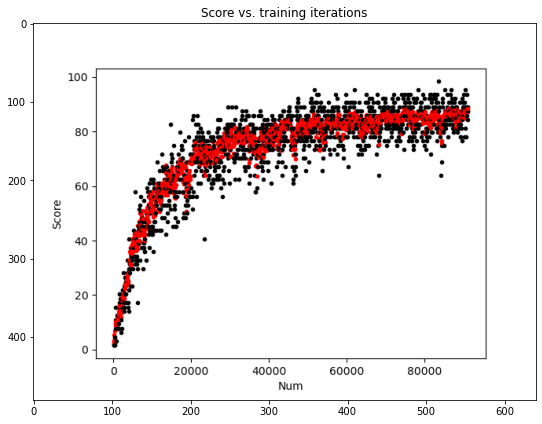

In [6]:
plt.figure(figsize = (9,9))
 
plt.title("Score vs. training iterations")
 
image = mpimg.imread(".\Figure_1.png")
plt.imshow(image)
plt.show()


#### 3.5 Training and testing accuracies comparison
Now let's look at the testing accuracy and training accuracy on larger training dataset basis and compare to see if this balance still stands

In [23]:
output_test = MDL(test_x)
_, predictedtest = torch.max(output_test, 1)
scoret = (sum(np.array(predictedtest.tolist()) == np.array(test_y)) / len(test_y)) * 100

output_train = MDL(X_train_transformed[:5000])
_, predictedtrain = torch.max(output_train, 1)
scoretr = (sum(np.array(predictedtrain.tolist()) == np.array(train_y[:5000])) / len(train_y[:5000])) * 100

print('The training accuracy for 5000 dataset is: %.2f' % scoretr)
print('The testing accuracy  is: %.2f' % scoret)

The training accuracy for 5000 dataset is: 91.38
The testing accuracy  is: 90.06


#### 3.6 Confusion matrix analysis / model performance analysis

In [81]:
from sklearn import metrics

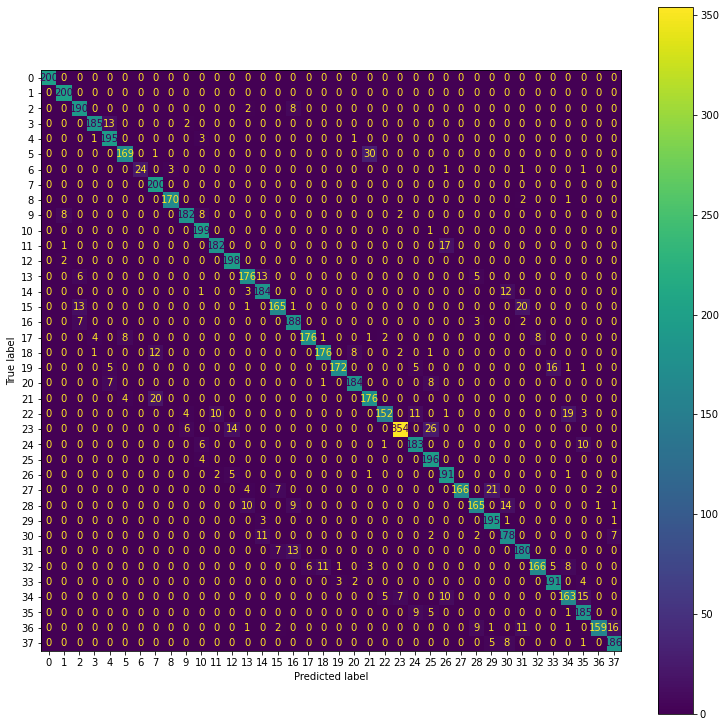

In [99]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(
                  np.array(test_y), np.array(predictedtest.tolist()), 
                  labels=range(38),
                  display_labels=range(38), 
                  values_format='',  
) 
fig = disp.ax_.get_figure() 
fig.set_figwidth(13)
fig.set_figheight(13)  

The above plot of confusion matrix gives us a general view on how our trained model performs on all 38 classes. Just by looking at the plot we can see the model performs well on all 38 classes with small error rates.

But now let's quantitatively look at how is our precesion / recall is doing for our trained model

First, we need to recall the definitions on precision and recall:

#### Precision = TP / (TP + FP)

#### Recall = TP / (TP + FN)

In [112]:
cm = metrics.confusion_matrix(np.array(test_y), np.array(predictedtest.tolist()))
cm

array([[200,   0,   0, ...,   0,   0,   0],
       [  0, 200,   0, ...,   0,   0,   0],
       [  0,   0, 190, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 185,   0,   0],
       [  0,   0,   0, ...,   0, 159,  16],
       [  0,   0,   0, ...,   1,   0, 186]], dtype=int64)

Now we have to look at precision / recall for each class so we would quantitatively know if the model is biasing on particular type of class or balancing on all of them.

We need to write a code to calculate individual precision and recall for each class

In [168]:
def calPre_Rec(classname, cm):
    TP = cm[classname][classname]
    FN = cm[classname].sum() - TP
    FP = np.array(cm)[:,[classname]].sum() - TP
    TN = cm.sum() - TP - FN - FP
    precision = TP / (TP + FP)   
    recall = TP / (TP + FN)
    return precision, recall

In [171]:
classname = range(38)
pre = []
rec = []
for i in classname:
    a, b = calPre_Rec(i, cm)
    pre.append(a)
    rec.append(b)

Text(0.5, 0, 'Class')

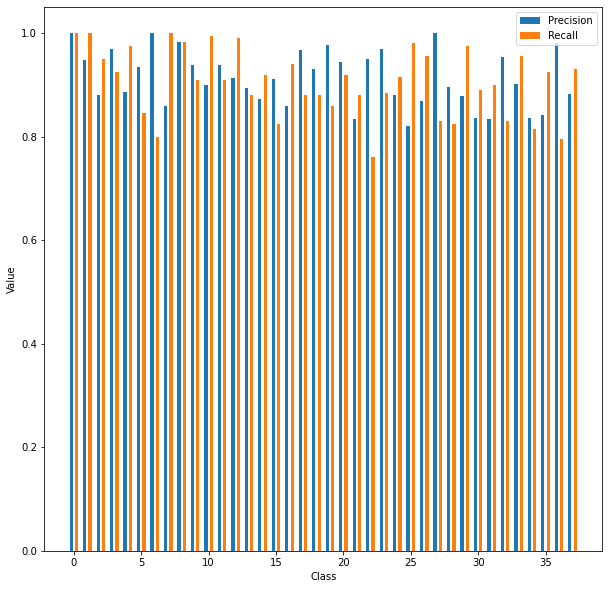

In [203]:
ind = np.arange(len(pre))  # the x locations for the groups
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize = (10,10))
precision = ax.bar(ind - width, pre, width*1.2, label='Precision')
recall = ax.bar(ind + width, rec, width*1.2, label='Recall')
plt.legend()
plt.ylabel('Value')
plt.xlabel('Class')

From this graph, we can see that the precision and recall for each class is generally balanced. However, we can see the recall for class 6 and class 22 are relatively low (~0.78)

In [205]:
print('The average precision for this model is %.2f' % np.mean(pre))
print('The average recall for this model is %.2f' % np.mean(rec))

The average precision for this model is 0.91
The average recall for this model is 0.91


### 4. Prediction check

This is just to demonstrate how the model performs at prediction

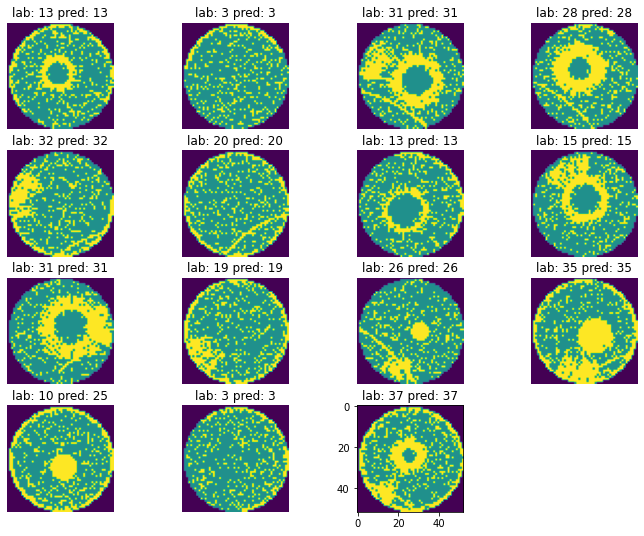

In [34]:
plt.figure(figsize = (12,9))
for i in range(1,16):
    plt.axis('off')
    plt.subplot(4,4,i)
    plt.imshow(X_valtest[i])
    plt.title('lab: %s pred: %s' % (test_y[i], predictedtest.tolist()[i]))

From above, we can see in these 16 images, only one image is misclassified using my new model.

### 5. New model summary

According to the above analysis, the newly customized LeNET is performing well for all dataset in general, and the following are the customized model details:

1. 1st conv layer output: 7
2. 1st conv layer kernel size: 3 x 3
3. 2nd conv layer output: 15
4. 2nd conv layer kernel size: 6 x 6
5. 1st dropout rate: 0.2445
6. 1st fully connected layer output: 117
7. 2nd dropout rate: 0.4108
8. 2nd fully connected layer output: 85
9. 3rd dropout rate: 0.3834
10. Max Pooling layer kernel size: 1 x 1
11. Max Pooling layer stride size: 1 x 1
12. Optimizer learning rate: 0.004593
13. Adam weight decaying factor: 0.0005107 

The following is the new configuration of the customized LeNET optimized for this wafer defect mapping dataset.

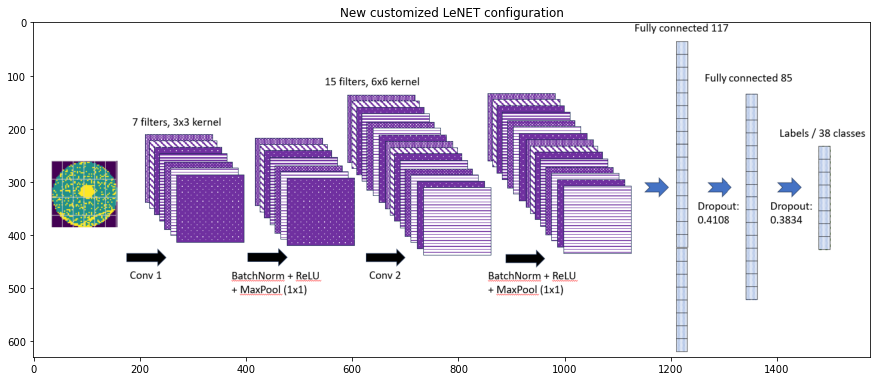

In [7]:
plt.figure(figsize = (15,9))
 
plt.title("New customized LeNET configuration")
 
image = mpimg.imread(".\Fig 2.png")
plt.imshow(image)
plt.show()

### 6. Conclusion
This new customized LeNET based model is performing well on the wafer defect map classification, and it has a balancing precision and recall across all classes. It's impressive that with only two layers of convolutional layers / units can achieve a testing accuracy above 90%. This new model is cheap in terms of calculating time, model building and model complexity. So this solution is cost-effective.

In hyperparameter tuning, I used Bayesian Optimization for searching the optimal hyperparameters, considering the large dataset and high dimensional feature space. Bayesian Optimization searching is more effective than Random Search and Grid Search. 

But more future work is needed to fine tune the model configuration to achieve even higher testing accuracy while keeping the balanced precision / recall. For example, using 3 convolutional units, or one more fully connected layer, or even transfer learning using some more sophisticated pre-trained model, e.g. AlexNET, GoogleLeNET, etc. 

